In [2]:
import wandb
from data_loaders import make_train_data, make_test_val_data, make_model
from train import train, test, precision, recall, f1_score
import torch
import time
import gc
import config_file
from clean_data_seq2point import load_all_houses_with_device
import random
import optuna
from data_loaders import PecanStreetDataset
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from lstm_seq2point import LSTM
from clean_data_seq2point import normalize_y
from sklearn import metrics
import pandas as pd
from scipy import stats
from matplotlib.lines import Line2D
import matplotlib.transforms

In [3]:
wandb.login()

print(torch.cuda.is_available())

gc.collect()
torch.cuda.empty_cache()

print(torch.__version__)

wandb: Currently logged in as: nilm (use `wandb login --relogin` to force relogin)


True
1.10.2


In [4]:
config_ = config_file.load_hyperparameters("refrigerator1")

In [5]:
homes = load_all_houses_with_device(config_file.path, config_['appliance'])

In [6]:
def model_pipeline(hyperparameters, train_months, test_month, appliance, window_length, train_buildings,
                   test_buildings, patience):
    with wandb.init(project="global_models_feb10", config=hyperparameters):
        wandb.run.name = str(config_['appliance'])+"_Test:"+str(test_buildings)+"_Train:" + str(train_buildings)

        config = wandb.config

        # lengths = [85320, 132480, 132480, 132480, 132480, 132480, 132480]

        model, criterion, optimizer = make_model(config)

        print(model)
        print("Window Length: ", window_length)

        wandb.watch(model, criterion, log="all", log_freq=10)

        example_ct = 0
        batch_ct = 0
        all_epochs = 0

        #Scheduler for training on single building
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.95, verbose=True)
        
        #base_lr: 0.001*lr, max_lr: 4*lr, step_size_up:50, step_size_down:2000
#         scheduler = torch.optim.lr_scheduler.CyclicLR(
#             optimizer,
#             base_lr = config_['learning_rate'], #0.01
#             max_lr = 1.1*config_['learning_rate'], #1
#             step_size_up = 10000, #200
#             step_size_down = 10000, #1000
#             gamma = 0.95, #1
#             cycle_momentum=False,
#             verbose=False
#         )

        validation_loader, test_loader, test_val_seq_std, test_val_seq_mean = make_test_val_data(
            config,
            test_month,
            appliance,
            window_length,
            test_buildings
        )

        time_log = time.time()
        train_loader, train_seq_std, train_seq_mean = make_train_data(
            config,
            train_months,
            appliance,
            window_length,
            train_buildings
        )
        
        model, example_ct, batch_ct, all_epochs, best_model = train( 
            model,
            train_loader,
            validation_loader,
            criterion,
            optimizer,
            config,
            example_ct,
            batch_ct,
            all_epochs,
            scheduler,
            test_val_seq_std,
            test_val_seq_mean,
            train_seq_std,
            train_seq_mean,
            patience
        )

        print("Time to train on one home: ", time.time() - time_log)

        results = test(best_model, test_loader, criterion, test_val_seq_std, test_val_seq_mean)

    return model, results, best_model


In [7]:
home_ids = homes.dataid.unique()

In [8]:
len(home_ids)

20

In [9]:
home_ids

array([  145,   183,   335,   387,   526,  1417,  2358,  3383,  4628,
        6240,  6526,  6672,  7021,  7069,  7365,  9004, 10554, 10811,
       10983, 11878], dtype=int64)

In [10]:
home_ids_train = [x for x in home_ids if x!=3383]

In [11]:
home_ids_train

[145,
 183,
 335,
 387,
 526,
 1417,
 2358,
 4628,
 6240,
 6526,
 6672,
 7021,
 7069,
 7365,
 9004,
 10554,
 10811,
 10983,
 11878]

In [12]:
random_select = [2,3,4,5,6,7,8,9,10,15,20]
#random_select = [len(home_ids)]
#random_select = [53]

In [13]:
PATH = r"C:\Users\aar245\Desktop\privacy_preserving_nn\models_power_ratio_filter"

In [14]:
train_homes_from_fl = [
    [5058, 2358, 8825, 10811, 526],
    [142, 10811, 2358, 6240, 2126, 1417, 7365, 5058, 10182, 9004],
    [9053, 2561, 2126, 7021, 526, 9973, 6178, 3700, 8825, 142, 7069, 335, 690, 6526, 183],
    [183, 6240, 5058, 6672, 8825, 3700, 7365, 9053, 3976, 9973, 6526, 3996, 526, 3488, 387, 11878, 7021, 10811, 9290, 6178],
    [6672, 9290, 6178, 10983, 3700, 6526, 3488, 6240, 9973, 3976, 9004, 2126, 3383, 142, 2358, 690, 7021, 387, 10182, 10811, 5058, 8825, 2561, 526, 3996],
    [526, 10811, 9973, 7021, 5058, 335, 3488, 9053, 10983, 3976, 11878, 142, 2561, 8825, 6672, 387, 183, 6178, 1417, 9290, 10182, 690, 2358, 7365, 3383, 6240, 7069, 9004, 3996, 3700],
    [5058, 2358, 3488, 10182, 6672, 11878, 7021, 6526, 335, 10164, 142, 9973, 10983, 6240, 2126, 1417, 7069, 6178, 8825, 3383, 9004, 387, 3976, 3700, 9290, 3996, 690, 7365, 9053, 183, 2561, 526, 10811]
]

In [15]:
test_homes_from_fl = [526, 5058, 526, 3488, 10983, 7021, 2358]

In [16]:
final_results = {}
random.seed(3)
train_homes = []
best_models = []
max_patience = 200
min_patience = 50
training_homes = [3383]

for i in home_ids_train:
    gc.collect()
    torch.cuda.empty_cache()
    #training_homes=[3383]
    training_homes.append(i)
    #training_homes = train_homes_from_fl[-1]
    testing_homes = [3383]
    #testing_homes = [test_homes_from_fl[-1]]
    #patience = int((max_patience-min_patience)/(1-random_select[-1])*len(training_homes)+max_patience+(max_patience-min_patience)/(1-random_select[-1]))
    patience = 20
    print("patience: ", patience)
    print("training_home: ", training_homes)
    print("test_home: ", testing_homes)
    model, per_house_result, best_model = model_pipeline(
    config_,
    'sept_oct_nov',
    'dec',
    config_['appliance'],
    config_['window_size'],
    training_homes,
    testing_homes,
    patience)
    result = {str(config_["appliance"])+"_Train_home_"+str(training_homes)+"_Test_home_"+str(testing_homes)+"_total_homes_"+str(1): per_house_result}
    final_results.update(result)
    print(final_results)
    #model.cpu()
    #torch.save(model.state_dict(), PATH+"\\refrigerator_model_total_houses_"+str(random_select[i])+"_trial_3.pth")
    best_model.cpu()
    model.cpu()
    best_models.append(best_model)
    torch.save(best_model.state_dict(), PATH+"\\seq2point_refrigerator_model_3383test_train"+str(len(training_homes))+"_homes_trial1.pth")

patience:  20
training_home:  [3383, 145]
test_home:  [3383]


wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


LSTM(
  (conv1): Conv1d(1, 30, kernel_size=(10,), stride=(1,))
  (conv2): Conv1d(30, 30, kernel_size=(8,), stride=(1,))
  (conv3): Conv1d(30, 40, kernel_size=(6,), stride=(1,))
  (conv4): Conv1d(40, 50, kernel_size=(5,), stride=(1,))
  (conv5): Conv1d(50, 50, kernel_size=(5,), stride=(1,))
  (linear1): Linear(in_features=23500, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=1, bias=True)
  (relu): ReLU()
  (leaky): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.2, inplace=False)
)
Window Length:  499
Adjusting learning rate of group 0 to 3.3181e-04.
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 0
Loss after 233700 batches: 0.6385
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 1
Loss after 467400 batches: 0.4323
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 2
Loss after 701100 batches: 0.3313
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 3
Loss after 934800 batches: 0.25

Test_F1_Score,▁
Test_Loss,▁
Test_MAE,▁
Test_MSE,▁
Test_NDE,▁
Test_NEP,▁
Test_R2_Value,▁
Training_F1,▁▃▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████████████████
Training_Loss,█▆▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training_MAE,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training_MSE,█▆▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


{'refrigerator1_Train_home_[3383, 145]_Test_home_[3383]_total_homes_1': [0.48835255901018776, 0.4722010240016288, 0.500879405682105, 0.9784157072511019, 0.4323700644417161, 23.115421771276807, 1334.7532]}
patience:  20
training_home:  [3383, 145, 183]
test_home:  [3383]


wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


LSTM(
  (conv1): Conv1d(1, 30, kernel_size=(10,), stride=(1,))
  (conv2): Conv1d(30, 30, kernel_size=(8,), stride=(1,))
  (conv3): Conv1d(30, 40, kernel_size=(6,), stride=(1,))
  (conv4): Conv1d(40, 50, kernel_size=(5,), stride=(1,))
  (conv5): Conv1d(50, 50, kernel_size=(5,), stride=(1,))
  (linear1): Linear(in_features=23500, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=1, bias=True)
  (relu): ReLU()
  (leaky): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.2, inplace=False)
)
Window Length:  499
Adjusting learning rate of group 0 to 3.3181e-04.
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 0
Loss after 364800 batches: 0.5370
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 1
Loss after 729600 batches: 0.3581
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 2
Loss after 1094400 batches: 0.2486
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 3
Loss after 1459200 batches: 0.

Test_F1_Score,▁
Test_Loss,▁
Test_MAE,▁
Test_MSE,▁
Test_NDE,▁
Test_NEP,▁
Test_R2_Value,▁
Training_F1,▁▃▄▅▆▆▆▇▇▇▇▇▇████████
Training_Loss,█▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Training_MAE,█▆▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Training_MSE,█▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁


{'refrigerator1_Train_home_[3383, 145]_Test_home_[3383]_total_homes_1': [0.48835255901018776, 0.4722010240016288, 0.500879405682105, 0.9784157072511019, 0.4323700644417161, 23.115421771276807, 1334.7532], 'refrigerator1_Train_home_[3383, 145, 183]_Test_home_[3383]_total_homes_1': [0.5857868274052938, 0.3662983092079293, 0.47840184004624153, 1.0600346433053338, 0.5191249952054428, 25.04369838972673, 1602.5712]}
patience:  20
training_home:  [3383, 145, 183, 335]
test_home:  [3383]


wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


LSTM(
  (conv1): Conv1d(1, 30, kernel_size=(10,), stride=(1,))
  (conv2): Conv1d(30, 30, kernel_size=(8,), stride=(1,))
  (conv3): Conv1d(30, 40, kernel_size=(6,), stride=(1,))
  (conv4): Conv1d(40, 50, kernel_size=(5,), stride=(1,))
  (conv5): Conv1d(50, 50, kernel_size=(5,), stride=(1,))
  (linear1): Linear(in_features=23500, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=1, bias=True)
  (relu): ReLU()
  (leaky): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.2, inplace=False)
)
Window Length:  499
Adjusting learning rate of group 0 to 3.3181e-04.
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 0
Loss after 495900 batches: 0.5861
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 0
Loss after 991800 batches: 0.4138
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 1
Loss after 1487700 batches: 0.3099
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 2
Loss after 1983600 batches: 0.

Test_F1_Score,▁
Test_Loss,▁
Test_MAE,▁
Test_MSE,▁
Test_NDE,▁
Test_NEP,▁
Test_R2_Value,▁
Training_F1,▁▃▄▅▅▆▆▇▇▇▇▇▇▇████████
Training_Loss,█▆▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Training_MAE,█▆▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Training_MSE,█▆▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁


{'refrigerator1_Train_home_[3383, 145]_Test_home_[3383]_total_homes_1': [0.48835255901018776, 0.4722010240016288, 0.500879405682105, 0.9784157072511019, 0.4323700644417161, 23.115421771276807, 1334.7532], 'refrigerator1_Train_home_[3383, 145, 183]_Test_home_[3383]_total_homes_1': [0.5857868274052938, 0.3662983092079293, 0.47840184004624153, 1.0600346433053338, 0.5191249952054428, 25.04369838972673, 1602.5712], 'refrigerator1_Train_home_[3383, 145, 183, 335]_Test_home_[3383]_total_homes_1': [0.6403339756859674, 0.3095003367487643, 0.376913692156315, 1.1431826138668957, 0.5656535868266659, 27.00809899645467, 1746.2078]}
patience:  20
training_home:  [3383, 145, 183, 335, 387]
test_home:  [3383]


wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


LSTM(
  (conv1): Conv1d(1, 30, kernel_size=(10,), stride=(1,))
  (conv2): Conv1d(30, 30, kernel_size=(8,), stride=(1,))
  (conv3): Conv1d(30, 40, kernel_size=(6,), stride=(1,))
  (conv4): Conv1d(40, 50, kernel_size=(5,), stride=(1,))
  (conv5): Conv1d(50, 50, kernel_size=(5,), stride=(1,))
  (linear1): Linear(in_features=23500, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=1, bias=True)
  (relu): ReLU()
  (leaky): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.2, inplace=False)
)
Window Length:  499
Adjusting learning rate of group 0 to 3.3181e-04.
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 0
Loss after 624540 batches: 0.5729
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 1
Loss after 1249080 batches: 0.3764
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 2
Loss after 1873620 batches: 0.2631
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 3
Loss after 2498160 batches: 0

Test_F1_Score,▁
Test_Loss,▁
Test_MAE,▁
Test_MSE,▁
Test_NDE,▁
Test_NEP,▁
Test_R2_Value,▁
Training_F1,▁▃▄▅▆▆▆▇▇▇▇▇▇████████
Training_Loss,█▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Training_MAE,█▆▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Training_MSE,█▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁


{'refrigerator1_Train_home_[3383, 145]_Test_home_[3383]_total_homes_1': [0.48835255901018776, 0.4722010240016288, 0.500879405682105, 0.9784157072511019, 0.4323700644417161, 23.115421771276807, 1334.7532], 'refrigerator1_Train_home_[3383, 145, 183]_Test_home_[3383]_total_homes_1': [0.5857868274052938, 0.3662983092079293, 0.47840184004624153, 1.0600346433053338, 0.5191249952054428, 25.04369838972673, 1602.5712], 'refrigerator1_Train_home_[3383, 145, 183, 335]_Test_home_[3383]_total_homes_1': [0.6403339756859674, 0.3095003367487643, 0.376913692156315, 1.1431826138668957, 0.5656535868266659, 27.00809899645467, 1746.2078], 'refrigerator1_Train_home_[3383, 145, 183, 335, 387]_Test_home_[3383]_total_homes_1': [0.6804485519727071, 0.2620496297170043, 0.43357659090918393, 1.2421575648091756, 0.6045249492015528, 29.346417687443424, 1866.206]}
patience:  20
training_home:  [3383, 145, 183, 335, 387, 526]
test_home:  [3383]


wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


LSTM(
  (conv1): Conv1d(1, 30, kernel_size=(10,), stride=(1,))
  (conv2): Conv1d(30, 30, kernel_size=(8,), stride=(1,))
  (conv3): Conv1d(30, 40, kernel_size=(6,), stride=(1,))
  (conv4): Conv1d(40, 50, kernel_size=(5,), stride=(1,))
  (conv5): Conv1d(50, 50, kernel_size=(5,), stride=(1,))
  (linear1): Linear(in_features=23500, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=1, bias=True)
  (relu): ReLU()
  (leaky): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.2, inplace=False)
)
Window Length:  499
Adjusting learning rate of group 0 to 3.3181e-04.
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 0
Loss after 755640 batches: 0.5783
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 1
Loss after 1511280 batches: 0.3954
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 2
Loss after 2266920 batches: 0.2778
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 3
Loss after 3022560 batches: 0

Test_F1_Score,▁
Test_Loss,▁
Test_MAE,▁
Test_MSE,▁
Test_NDE,▁
Test_NEP,▁
Test_R2_Value,▁
Training_F1,▁▃▄▅▆▆▆▇▇▇▇▇▇████████
Training_Loss,█▆▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Training_MAE,█▆▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Training_MSE,█▆▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁


{'refrigerator1_Train_home_[3383, 145]_Test_home_[3383]_total_homes_1': [0.48835255901018776, 0.4722010240016288, 0.500879405682105, 0.9784157072511019, 0.4323700644417161, 23.115421771276807, 1334.7532], 'refrigerator1_Train_home_[3383, 145, 183]_Test_home_[3383]_total_homes_1': [0.5857868274052938, 0.3662983092079293, 0.47840184004624153, 1.0600346433053338, 0.5191249952054428, 25.04369838972673, 1602.5712], 'refrigerator1_Train_home_[3383, 145, 183, 335]_Test_home_[3383]_total_homes_1': [0.6403339756859674, 0.3095003367487643, 0.376913692156315, 1.1431826138668957, 0.5656535868266659, 27.00809899645467, 1746.2078], 'refrigerator1_Train_home_[3383, 145, 183, 335, 387]_Test_home_[3383]_total_homes_1': [0.6804485519727071, 0.2620496297170043, 0.43357659090918393, 1.2421575648091756, 0.6045249492015528, 29.346417687443424, 1866.206], 'refrigerator1_Train_home_[3383, 145, 183, 335, 387, 526]_Test_home_[3383]_total_homes_1': [0.7144321905242073, 0.22986878917519105, 0.2059222970458523, 1.

wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


LSTM(
  (conv1): Conv1d(1, 30, kernel_size=(10,), stride=(1,))
  (conv2): Conv1d(30, 30, kernel_size=(8,), stride=(1,))
  (conv3): Conv1d(30, 40, kernel_size=(6,), stride=(1,))
  (conv4): Conv1d(40, 50, kernel_size=(5,), stride=(1,))
  (conv5): Conv1d(50, 50, kernel_size=(5,), stride=(1,))
  (linear1): Linear(in_features=23500, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=1, bias=True)
  (relu): ReLU()
  (leaky): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.2, inplace=False)
)
Window Length:  499
Adjusting learning rate of group 0 to 3.3181e-04.
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 0
Loss after 886740 batches: 0.6060
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 1
Loss after 1773480 batches: 0.4160
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 2
Loss after 2660220 batches: 0.2877
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 3
Loss after 3546960 batches: 0

Test_F1_Score,▁
Test_Loss,▁
Test_MAE,▁
Test_MSE,▁
Test_NDE,▁
Test_NEP,▁
Test_R2_Value,▁
Training_F1,▁▃▄▅▆▆▇▇▇▇▇▇▇████████
Training_Loss,█▆▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Training_MAE,█▆▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Training_MSE,█▆▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁


{'refrigerator1_Train_home_[3383, 145]_Test_home_[3383]_total_homes_1': [0.48835255901018776, 0.4722010240016288, 0.500879405682105, 0.9784157072511019, 0.4323700644417161, 23.115421771276807, 1334.7532], 'refrigerator1_Train_home_[3383, 145, 183]_Test_home_[3383]_total_homes_1': [0.5857868274052938, 0.3662983092079293, 0.47840184004624153, 1.0600346433053338, 0.5191249952054428, 25.04369838972673, 1602.5712], 'refrigerator1_Train_home_[3383, 145, 183, 335]_Test_home_[3383]_total_homes_1': [0.6403339756859674, 0.3095003367487643, 0.376913692156315, 1.1431826138668957, 0.5656535868266659, 27.00809899645467, 1746.2078], 'refrigerator1_Train_home_[3383, 145, 183, 335, 387]_Test_home_[3383]_total_homes_1': [0.6804485519727071, 0.2620496297170043, 0.43357659090918393, 1.2421575648091756, 0.6045249492015528, 29.346417687443424, 1866.206], 'refrigerator1_Train_home_[3383, 145, 183, 335, 387, 526]_Test_home_[3383]_total_homes_1': [0.7144321905242073, 0.22986878917519105, 0.2059222970458523, 1.

wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


LSTM(
  (conv1): Conv1d(1, 30, kernel_size=(10,), stride=(1,))
  (conv2): Conv1d(30, 30, kernel_size=(8,), stride=(1,))
  (conv3): Conv1d(30, 40, kernel_size=(6,), stride=(1,))
  (conv4): Conv1d(40, 50, kernel_size=(5,), stride=(1,))
  (conv5): Conv1d(50, 50, kernel_size=(5,), stride=(1,))
  (linear1): Linear(in_features=23500, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=1, bias=True)
  (relu): ReLU()
  (leaky): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.2, inplace=False)
)
Window Length:  499
Adjusting learning rate of group 0 to 3.3181e-04.
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 0
Loss after 1017840 batches: 0.5664
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 1
Loss after 2035680 batches: 0.3898
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 2
Loss after 3053520 batches: 0.2680
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 3
Loss after 4071360 batches: 

Test_F1_Score,▁
Test_Loss,▁
Test_MAE,▁
Test_MSE,▁
Test_NDE,▁
Test_NEP,▁
Test_R2_Value,▁
Training_F1,▁▃▄▅▆▆▇▇▇▇▇▇▇████████
Training_Loss,█▆▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Training_MAE,█▆▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Training_MSE,█▆▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁


{'refrigerator1_Train_home_[3383, 145]_Test_home_[3383]_total_homes_1': [0.48835255901018776, 0.4722010240016288, 0.500879405682105, 0.9784157072511019, 0.4323700644417161, 23.115421771276807, 1334.7532], 'refrigerator1_Train_home_[3383, 145, 183]_Test_home_[3383]_total_homes_1': [0.5857868274052938, 0.3662983092079293, 0.47840184004624153, 1.0600346433053338, 0.5191249952054428, 25.04369838972673, 1602.5712], 'refrigerator1_Train_home_[3383, 145, 183, 335]_Test_home_[3383]_total_homes_1': [0.6403339756859674, 0.3095003367487643, 0.376913692156315, 1.1431826138668957, 0.5656535868266659, 27.00809899645467, 1746.2078], 'refrigerator1_Train_home_[3383, 145, 183, 335, 387]_Test_home_[3383]_total_homes_1': [0.6804485519727071, 0.2620496297170043, 0.43357659090918393, 1.2421575648091756, 0.6045249492015528, 29.346417687443424, 1866.206], 'refrigerator1_Train_home_[3383, 145, 183, 335, 387, 526]_Test_home_[3383]_total_homes_1': [0.7144321905242073, 0.22986878917519105, 0.2059222970458523, 1.

wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


LSTM(
  (conv1): Conv1d(1, 30, kernel_size=(10,), stride=(1,))
  (conv2): Conv1d(30, 30, kernel_size=(8,), stride=(1,))
  (conv3): Conv1d(30, 40, kernel_size=(6,), stride=(1,))
  (conv4): Conv1d(40, 50, kernel_size=(5,), stride=(1,))
  (conv5): Conv1d(50, 50, kernel_size=(5,), stride=(1,))
  (linear1): Linear(in_features=23500, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=1, bias=True)
  (relu): ReLU()
  (leaky): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.2, inplace=False)
)
Window Length:  499
Adjusting learning rate of group 0 to 3.3181e-04.
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 0
Loss after 1096440 batches: 0.5678
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 1
Loss after 2192880 batches: 0.3903
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 2
Loss after 3289320 batches: 0.2728
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 3
Loss after 4385760 batches: 

Test_F1_Score,▁
Test_Loss,▁
Test_MAE,▁
Test_MSE,▁
Test_NDE,▁
Test_NEP,▁
Test_R2_Value,▁
Training_F1,▁▃▄▅▆▆▇▇▇▇▇▇▇████████
Training_Loss,█▆▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Training_MAE,█▆▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Training_MSE,█▆▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁


{'refrigerator1_Train_home_[3383, 145]_Test_home_[3383]_total_homes_1': [0.48835255901018776, 0.4722010240016288, 0.500879405682105, 0.9784157072511019, 0.4323700644417161, 23.115421771276807, 1334.7532], 'refrigerator1_Train_home_[3383, 145, 183]_Test_home_[3383]_total_homes_1': [0.5857868274052938, 0.3662983092079293, 0.47840184004624153, 1.0600346433053338, 0.5191249952054428, 25.04369838972673, 1602.5712], 'refrigerator1_Train_home_[3383, 145, 183, 335]_Test_home_[3383]_total_homes_1': [0.6403339756859674, 0.3095003367487643, 0.376913692156315, 1.1431826138668957, 0.5656535868266659, 27.00809899645467, 1746.2078], 'refrigerator1_Train_home_[3383, 145, 183, 335, 387]_Test_home_[3383]_total_homes_1': [0.6804485519727071, 0.2620496297170043, 0.43357659090918393, 1.2421575648091756, 0.6045249492015528, 29.346417687443424, 1866.206], 'refrigerator1_Train_home_[3383, 145, 183, 335, 387, 526]_Test_home_[3383]_total_homes_1': [0.7144321905242073, 0.22986878917519105, 0.2059222970458523, 1.

wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


LSTM(
  (conv1): Conv1d(1, 30, kernel_size=(10,), stride=(1,))
  (conv2): Conv1d(30, 30, kernel_size=(8,), stride=(1,))
  (conv3): Conv1d(30, 40, kernel_size=(6,), stride=(1,))
  (conv4): Conv1d(40, 50, kernel_size=(5,), stride=(1,))
  (conv5): Conv1d(50, 50, kernel_size=(5,), stride=(1,))
  (linear1): Linear(in_features=23500, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=1, bias=True)
  (relu): ReLU()
  (leaky): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.2, inplace=False)
)
Window Length:  499
Adjusting learning rate of group 0 to 3.3181e-04.
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 0
Loss after 1227540 batches: 0.5629
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 1
Loss after 2455080 batches: 0.3972
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 2
Loss after 3682620 batches: 0.2861
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 3
Loss after 4910160 batches: 

Test_F1_Score,▁
Test_Loss,▁
Test_MAE,▁
Test_MSE,▁
Test_NDE,▁
Test_NEP,▁
Test_R2_Value,▁
Training_F1,▁▃▄▅▆▆▇▇▇▇▇▇▇████████
Training_Loss,█▆▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Training_MAE,█▆▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Training_MSE,█▆▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁


{'refrigerator1_Train_home_[3383, 145]_Test_home_[3383]_total_homes_1': [0.48835255901018776, 0.4722010240016288, 0.500879405682105, 0.9784157072511019, 0.4323700644417161, 23.115421771276807, 1334.7532], 'refrigerator1_Train_home_[3383, 145, 183]_Test_home_[3383]_total_homes_1': [0.5857868274052938, 0.3662983092079293, 0.47840184004624153, 1.0600346433053338, 0.5191249952054428, 25.04369838972673, 1602.5712], 'refrigerator1_Train_home_[3383, 145, 183, 335]_Test_home_[3383]_total_homes_1': [0.6403339756859674, 0.3095003367487643, 0.376913692156315, 1.1431826138668957, 0.5656535868266659, 27.00809899645467, 1746.2078], 'refrigerator1_Train_home_[3383, 145, 183, 335, 387]_Test_home_[3383]_total_homes_1': [0.6804485519727071, 0.2620496297170043, 0.43357659090918393, 1.2421575648091756, 0.6045249492015528, 29.346417687443424, 1866.206], 'refrigerator1_Train_home_[3383, 145, 183, 335, 387, 526]_Test_home_[3383]_total_homes_1': [0.7144321905242073, 0.22986878917519105, 0.2059222970458523, 1.

wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


LSTM(
  (conv1): Conv1d(1, 30, kernel_size=(10,), stride=(1,))
  (conv2): Conv1d(30, 30, kernel_size=(8,), stride=(1,))
  (conv3): Conv1d(30, 40, kernel_size=(6,), stride=(1,))
  (conv4): Conv1d(40, 50, kernel_size=(5,), stride=(1,))
  (conv5): Conv1d(50, 50, kernel_size=(5,), stride=(1,))
  (linear1): Linear(in_features=23500, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=1, bias=True)
  (relu): ReLU()
  (leaky): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.2, inplace=False)
)
Window Length:  499
Adjusting learning rate of group 0 to 3.3181e-04.
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 0
Loss after 1358640 batches: 0.5193
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 1
Loss after 2717280 batches: 0.3408
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 2
Loss after 4075920 batches: 0.2282
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 3
Loss after 5434560 batches: 

Test_F1_Score,▁
Test_Loss,▁
Test_MAE,▁
Test_MSE,▁
Test_NDE,▁
Test_NEP,▁
Test_R2_Value,▁
Training_F1,▁▃▅▅▆▆▇▇▇▇▇▇█████████
Training_Loss,█▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Training_MAE,█▆▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Training_MSE,█▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁


{'refrigerator1_Train_home_[3383, 145]_Test_home_[3383]_total_homes_1': [0.48835255901018776, 0.4722010240016288, 0.500879405682105, 0.9784157072511019, 0.4323700644417161, 23.115421771276807, 1334.7532], 'refrigerator1_Train_home_[3383, 145, 183]_Test_home_[3383]_total_homes_1': [0.5857868274052938, 0.3662983092079293, 0.47840184004624153, 1.0600346433053338, 0.5191249952054428, 25.04369838972673, 1602.5712], 'refrigerator1_Train_home_[3383, 145, 183, 335]_Test_home_[3383]_total_homes_1': [0.6403339756859674, 0.3095003367487643, 0.376913692156315, 1.1431826138668957, 0.5656535868266659, 27.00809899645467, 1746.2078], 'refrigerator1_Train_home_[3383, 145, 183, 335, 387]_Test_home_[3383]_total_homes_1': [0.6804485519727071, 0.2620496297170043, 0.43357659090918393, 1.2421575648091756, 0.6045249492015528, 29.346417687443424, 1866.206], 'refrigerator1_Train_home_[3383, 145, 183, 335, 387, 526]_Test_home_[3383]_total_homes_1': [0.7144321905242073, 0.22986878917519105, 0.2059222970458523, 1.

wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


LSTM(
  (conv1): Conv1d(1, 30, kernel_size=(10,), stride=(1,))
  (conv2): Conv1d(30, 30, kernel_size=(8,), stride=(1,))
  (conv3): Conv1d(30, 40, kernel_size=(6,), stride=(1,))
  (conv4): Conv1d(40, 50, kernel_size=(5,), stride=(1,))
  (conv5): Conv1d(50, 50, kernel_size=(5,), stride=(1,))
  (linear1): Linear(in_features=23500, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=1, bias=True)
  (relu): ReLU()
  (leaky): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.2, inplace=False)
)
Window Length:  499
Adjusting learning rate of group 0 to 3.3181e-04.
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 0
Loss after 1489740 batches: 0.5188
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 0
Loss after 2979480 batches: 0.3277
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 1
Loss after 4469220 batches: 0.2202
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 2
Loss after 5958960 batches: 

Test_F1_Score,▁
Test_Loss,▁
Test_MAE,▁
Test_MSE,▁
Test_NDE,▁
Test_NEP,▁
Test_R2_Value,▁
Training_F1,▁▃▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
Training_Loss,█▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training_MAE,█▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training_MSE,█▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


{'refrigerator1_Train_home_[3383, 145]_Test_home_[3383]_total_homes_1': [0.48835255901018776, 0.4722010240016288, 0.500879405682105, 0.9784157072511019, 0.4323700644417161, 23.115421771276807, 1334.7532], 'refrigerator1_Train_home_[3383, 145, 183]_Test_home_[3383]_total_homes_1': [0.5857868274052938, 0.3662983092079293, 0.47840184004624153, 1.0600346433053338, 0.5191249952054428, 25.04369838972673, 1602.5712], 'refrigerator1_Train_home_[3383, 145, 183, 335]_Test_home_[3383]_total_homes_1': [0.6403339756859674, 0.3095003367487643, 0.376913692156315, 1.1431826138668957, 0.5656535868266659, 27.00809899645467, 1746.2078], 'refrigerator1_Train_home_[3383, 145, 183, 335, 387]_Test_home_[3383]_total_homes_1': [0.6804485519727071, 0.2620496297170043, 0.43357659090918393, 1.2421575648091756, 0.6045249492015528, 29.346417687443424, 1866.206], 'refrigerator1_Train_home_[3383, 145, 183, 335, 387, 526]_Test_home_[3383]_total_homes_1': [0.7144321905242073, 0.22986878917519105, 0.2059222970458523, 1.

wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


LSTM(
  (conv1): Conv1d(1, 30, kernel_size=(10,), stride=(1,))
  (conv2): Conv1d(30, 30, kernel_size=(8,), stride=(1,))
  (conv3): Conv1d(30, 40, kernel_size=(6,), stride=(1,))
  (conv4): Conv1d(40, 50, kernel_size=(5,), stride=(1,))
  (conv5): Conv1d(50, 50, kernel_size=(5,), stride=(1,))
  (linear1): Linear(in_features=23500, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=1, bias=True)
  (relu): ReLU()
  (leaky): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.2, inplace=False)
)
Window Length:  499
Adjusting learning rate of group 0 to 3.3181e-04.
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 0
Loss after 1620840 batches: 0.5636
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 1
Loss after 3241680 batches: 0.3835
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 2
Loss after 4862520 batches: 0.2642
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 3
Loss after 6483360 batches: 

Test_F1_Score,▁
Test_Loss,▁
Test_MAE,▁
Test_MSE,▁
Test_NDE,▁
Test_NEP,▁
Test_R2_Value,▁
Training_F1,▁▃▄▅▆▆▇▇▇▇▇▇█████████
Training_Loss,█▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Training_MAE,█▆▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Training_MSE,█▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁


{'refrigerator1_Train_home_[3383, 145]_Test_home_[3383]_total_homes_1': [0.48835255901018776, 0.4722010240016288, 0.500879405682105, 0.9784157072511019, 0.4323700644417161, 23.115421771276807, 1334.7532], 'refrigerator1_Train_home_[3383, 145, 183]_Test_home_[3383]_total_homes_1': [0.5857868274052938, 0.3662983092079293, 0.47840184004624153, 1.0600346433053338, 0.5191249952054428, 25.04369838972673, 1602.5712], 'refrigerator1_Train_home_[3383, 145, 183, 335]_Test_home_[3383]_total_homes_1': [0.6403339756859674, 0.3095003367487643, 0.376913692156315, 1.1431826138668957, 0.5656535868266659, 27.00809899645467, 1746.2078], 'refrigerator1_Train_home_[3383, 145, 183, 335, 387]_Test_home_[3383]_total_homes_1': [0.6804485519727071, 0.2620496297170043, 0.43357659090918393, 1.2421575648091756, 0.6045249492015528, 29.346417687443424, 1866.206], 'refrigerator1_Train_home_[3383, 145, 183, 335, 387, 526]_Test_home_[3383]_total_homes_1': [0.7144321905242073, 0.22986878917519105, 0.2059222970458523, 1.

wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


LSTM(
  (conv1): Conv1d(1, 30, kernel_size=(10,), stride=(1,))
  (conv2): Conv1d(30, 30, kernel_size=(8,), stride=(1,))
  (conv3): Conv1d(30, 40, kernel_size=(6,), stride=(1,))
  (conv4): Conv1d(40, 50, kernel_size=(5,), stride=(1,))
  (conv5): Conv1d(50, 50, kernel_size=(5,), stride=(1,))
  (linear1): Linear(in_features=23500, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=1, bias=True)
  (relu): ReLU()
  (leaky): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.2, inplace=False)
)
Window Length:  499
Adjusting learning rate of group 0 to 3.3181e-04.
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 0
Loss after 1751940 batches: 0.5350
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 1
Loss after 3503880 batches: 0.3417
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 2
Loss after 5255820 batches: 0.2300
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 3
Loss after 7007760 batches: 

Test_F1_Score,▁
Test_Loss,▁
Test_MAE,▁
Test_MSE,▁
Test_NDE,▁
Test_NEP,▁
Test_R2_Value,▁
Training_F1,▁▃▅▅▆▆▇▇▇▇▇▇█████████
Training_Loss,█▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Training_MAE,█▆▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Training_MSE,█▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁


{'refrigerator1_Train_home_[3383, 145]_Test_home_[3383]_total_homes_1': [0.48835255901018776, 0.4722010240016288, 0.500879405682105, 0.9784157072511019, 0.4323700644417161, 23.115421771276807, 1334.7532], 'refrigerator1_Train_home_[3383, 145, 183]_Test_home_[3383]_total_homes_1': [0.5857868274052938, 0.3662983092079293, 0.47840184004624153, 1.0600346433053338, 0.5191249952054428, 25.04369838972673, 1602.5712], 'refrigerator1_Train_home_[3383, 145, 183, 335]_Test_home_[3383]_total_homes_1': [0.6403339756859674, 0.3095003367487643, 0.376913692156315, 1.1431826138668957, 0.5656535868266659, 27.00809899645467, 1746.2078], 'refrigerator1_Train_home_[3383, 145, 183, 335, 387]_Test_home_[3383]_total_homes_1': [0.6804485519727071, 0.2620496297170043, 0.43357659090918393, 1.2421575648091756, 0.6045249492015528, 29.346417687443424, 1866.206], 'refrigerator1_Train_home_[3383, 145, 183, 335, 387, 526]_Test_home_[3383]_total_homes_1': [0.7144321905242073, 0.22986878917519105, 0.2059222970458523, 1.

wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


LSTM(
  (conv1): Conv1d(1, 30, kernel_size=(10,), stride=(1,))
  (conv2): Conv1d(30, 30, kernel_size=(8,), stride=(1,))
  (conv3): Conv1d(30, 40, kernel_size=(6,), stride=(1,))
  (conv4): Conv1d(40, 50, kernel_size=(5,), stride=(1,))
  (conv5): Conv1d(50, 50, kernel_size=(5,), stride=(1,))
  (linear1): Linear(in_features=23500, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=1, bias=True)
  (relu): ReLU()
  (leaky): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.2, inplace=False)
)
Window Length:  499
Adjusting learning rate of group 0 to 3.3181e-04.
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 0
Loss after 1883040 batches: 0.5432
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 1
Loss after 3766080 batches: 0.3381
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 2
Loss after 5649120 batches: 0.2274
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 3
Loss after 7532160 batches: 

Test_F1_Score,▁
Test_Loss,▁
Test_MAE,▁
Test_MSE,▁
Test_NDE,▁
Test_NEP,▁
Test_R2_Value,▁
Training_F1,▁▃▅▆▆▇▇▇▇▇▇▇█████████
Training_Loss,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Training_MAE,█▆▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Training_MSE,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁


{'refrigerator1_Train_home_[3383, 145]_Test_home_[3383]_total_homes_1': [0.48835255901018776, 0.4722010240016288, 0.500879405682105, 0.9784157072511019, 0.4323700644417161, 23.115421771276807, 1334.7532], 'refrigerator1_Train_home_[3383, 145, 183]_Test_home_[3383]_total_homes_1': [0.5857868274052938, 0.3662983092079293, 0.47840184004624153, 1.0600346433053338, 0.5191249952054428, 25.04369838972673, 1602.5712], 'refrigerator1_Train_home_[3383, 145, 183, 335]_Test_home_[3383]_total_homes_1': [0.6403339756859674, 0.3095003367487643, 0.376913692156315, 1.1431826138668957, 0.5656535868266659, 27.00809899645467, 1746.2078], 'refrigerator1_Train_home_[3383, 145, 183, 335, 387]_Test_home_[3383]_total_homes_1': [0.6804485519727071, 0.2620496297170043, 0.43357659090918393, 1.2421575648091756, 0.6045249492015528, 29.346417687443424, 1866.206], 'refrigerator1_Train_home_[3383, 145, 183, 335, 387, 526]_Test_home_[3383]_total_homes_1': [0.7144321905242073, 0.22986878917519105, 0.2059222970458523, 1.

wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


LSTM(
  (conv1): Conv1d(1, 30, kernel_size=(10,), stride=(1,))
  (conv2): Conv1d(30, 30, kernel_size=(8,), stride=(1,))
  (conv3): Conv1d(30, 40, kernel_size=(6,), stride=(1,))
  (conv4): Conv1d(40, 50, kernel_size=(5,), stride=(1,))
  (conv5): Conv1d(50, 50, kernel_size=(5,), stride=(1,))
  (linear1): Linear(in_features=23500, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=1, bias=True)
  (relu): ReLU()
  (leaky): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.2, inplace=False)
)
Window Length:  499
Adjusting learning rate of group 0 to 3.3181e-04.
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 0
Loss after 2014140 batches: 0.5471
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 1
Loss after 4028280 batches: 0.3393
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 2
Loss after 6042420 batches: 0.2328
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 0
Loss after 8056560 batches: 

Test_F1_Score,▁
Test_Loss,▁
Test_MAE,▁
Test_MSE,▁
Test_NDE,▁
Test_NEP,▁
Test_R2_Value,▁
Training_F1,▁▃▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
Training_Loss,█▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training_MAE,█▆▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training_MSE,█▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


{'refrigerator1_Train_home_[3383, 145]_Test_home_[3383]_total_homes_1': [0.48835255901018776, 0.4722010240016288, 0.500879405682105, 0.9784157072511019, 0.4323700644417161, 23.115421771276807, 1334.7532], 'refrigerator1_Train_home_[3383, 145, 183]_Test_home_[3383]_total_homes_1': [0.5857868274052938, 0.3662983092079293, 0.47840184004624153, 1.0600346433053338, 0.5191249952054428, 25.04369838972673, 1602.5712], 'refrigerator1_Train_home_[3383, 145, 183, 335]_Test_home_[3383]_total_homes_1': [0.6403339756859674, 0.3095003367487643, 0.376913692156315, 1.1431826138668957, 0.5656535868266659, 27.00809899645467, 1746.2078], 'refrigerator1_Train_home_[3383, 145, 183, 335, 387]_Test_home_[3383]_total_homes_1': [0.6804485519727071, 0.2620496297170043, 0.43357659090918393, 1.2421575648091756, 0.6045249492015528, 29.346417687443424, 1866.206], 'refrigerator1_Train_home_[3383, 145, 183, 335, 387, 526]_Test_home_[3383]_total_homes_1': [0.7144321905242073, 0.22986878917519105, 0.2059222970458523, 1.

wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


LSTM(
  (conv1): Conv1d(1, 30, kernel_size=(10,), stride=(1,))
  (conv2): Conv1d(30, 30, kernel_size=(8,), stride=(1,))
  (conv3): Conv1d(30, 40, kernel_size=(6,), stride=(1,))
  (conv4): Conv1d(40, 50, kernel_size=(5,), stride=(1,))
  (conv5): Conv1d(50, 50, kernel_size=(5,), stride=(1,))
  (linear1): Linear(in_features=23500, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=1, bias=True)
  (relu): ReLU()
  (leaky): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.2, inplace=False)
)
Window Length:  499
Adjusting learning rate of group 0 to 3.3181e-04.
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 0
Loss after 2108100 batches: 0.5725
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 1
Loss after 4216200 batches: 0.3738
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 2
Loss after 6324300 batches: 0.2621
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 3
Loss after 8432400 batches: 

Test_F1_Score,▁
Test_Loss,▁
Test_MAE,▁
Test_MSE,▁
Test_NDE,▁
Test_NEP,▁
Test_R2_Value,▁
Training_F1,▁▃▅▆▆▆▇▇▇▇▇▇█████████
Training_Loss,█▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Training_MAE,█▆▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Training_MSE,█▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁


{'refrigerator1_Train_home_[3383, 145]_Test_home_[3383]_total_homes_1': [0.48835255901018776, 0.4722010240016288, 0.500879405682105, 0.9784157072511019, 0.4323700644417161, 23.115421771276807, 1334.7532], 'refrigerator1_Train_home_[3383, 145, 183]_Test_home_[3383]_total_homes_1': [0.5857868274052938, 0.3662983092079293, 0.47840184004624153, 1.0600346433053338, 0.5191249952054428, 25.04369838972673, 1602.5712], 'refrigerator1_Train_home_[3383, 145, 183, 335]_Test_home_[3383]_total_homes_1': [0.6403339756859674, 0.3095003367487643, 0.376913692156315, 1.1431826138668957, 0.5656535868266659, 27.00809899645467, 1746.2078], 'refrigerator1_Train_home_[3383, 145, 183, 335, 387]_Test_home_[3383]_total_homes_1': [0.6804485519727071, 0.2620496297170043, 0.43357659090918393, 1.2421575648091756, 0.6045249492015528, 29.346417687443424, 1866.206], 'refrigerator1_Train_home_[3383, 145, 183, 335, 387, 526]_Test_home_[3383]_total_homes_1': [0.7144321905242073, 0.22986878917519105, 0.2059222970458523, 1.

wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


LSTM(
  (conv1): Conv1d(1, 30, kernel_size=(10,), stride=(1,))
  (conv2): Conv1d(30, 30, kernel_size=(8,), stride=(1,))
  (conv3): Conv1d(30, 40, kernel_size=(6,), stride=(1,))
  (conv4): Conv1d(40, 50, kernel_size=(5,), stride=(1,))
  (conv5): Conv1d(50, 50, kernel_size=(5,), stride=(1,))
  (linear1): Linear(in_features=23500, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=1, bias=True)
  (relu): ReLU()
  (leaky): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.2, inplace=False)
)
Window Length:  499
Adjusting learning rate of group 0 to 3.3181e-04.
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 0
Loss after 2239200 batches: 0.5262
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 1
Loss after 4478400 batches: 0.3239
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 2
Loss after 6717600 batches: 0.2200
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 3
Loss after 8956800 batches: 

trigger times: 2
Loss after 165700800 batches: 0.0377
Adjusting learning rate of group 0 to 1.5372e-04.
trigger times: 3
Loss after 167940000 batches: 0.0375
Adjusting learning rate of group 0 to 1.5372e-04.
trigger times: 4
Loss after 170179200 batches: 0.0373
Adjusting learning rate of group 0 to 1.5372e-04.
trigger times: 5
Loss after 172418400 batches: 0.0371
Adjusting learning rate of group 0 to 1.5372e-04.
trigger times: 6
Loss after 174657600 batches: 0.0369
Adjusting learning rate of group 0 to 1.5372e-04.
trigger times: 7
Loss after 176896800 batches: 0.0369
Adjusting learning rate of group 0 to 1.4604e-04.
trigger times: 8
Loss after 179136000 batches: 0.0368
Adjusting learning rate of group 0 to 1.4604e-04.
trigger times: 9
Loss after 181375200 batches: 0.0366
Adjusting learning rate of group 0 to 1.4604e-04.
trigger times: 10
Loss after 183614400 batches: 0.0364
Adjusting learning rate of group 0 to 1.4604e-04.
trigger times: 11
Loss after 185853600 batches: 0.0362
Adjustin

Test_F1_Score,▁
Test_Loss,▁
Test_MAE,▁
Test_MSE,▁
Test_NDE,▁
Test_NEP,▁
Test_R2_Value,▁
Training_F1,▁▄▆▆▇▇▇▇▇▇▇▇▇▇▇█████████████████████████
Training_Loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training_MAE,█▅▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training_MSE,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


{'refrigerator1_Train_home_[3383, 145]_Test_home_[3383]_total_homes_1': [0.48835255901018776, 0.4722010240016288, 0.500879405682105, 0.9784157072511019, 0.4323700644417161, 23.115421771276807, 1334.7532], 'refrigerator1_Train_home_[3383, 145, 183]_Test_home_[3383]_total_homes_1': [0.5857868274052938, 0.3662983092079293, 0.47840184004624153, 1.0600346433053338, 0.5191249952054428, 25.04369838972673, 1602.5712], 'refrigerator1_Train_home_[3383, 145, 183, 335]_Test_home_[3383]_total_homes_1': [0.6403339756859674, 0.3095003367487643, 0.376913692156315, 1.1431826138668957, 0.5656535868266659, 27.00809899645467, 1746.2078], 'refrigerator1_Train_home_[3383, 145, 183, 335, 387]_Test_home_[3383]_total_homes_1': [0.6804485519727071, 0.2620496297170043, 0.43357659090918393, 1.2421575648091756, 0.6045249492015528, 29.346417687443424, 1866.206], 'refrigerator1_Train_home_[3383, 145, 183, 335, 387, 526]_Test_home_[3383]_total_homes_1': [0.7144321905242073, 0.22986878917519105, 0.2059222970458523, 1.

wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


LSTM(
  (conv1): Conv1d(1, 30, kernel_size=(10,), stride=(1,))
  (conv2): Conv1d(30, 30, kernel_size=(8,), stride=(1,))
  (conv3): Conv1d(30, 40, kernel_size=(6,), stride=(1,))
  (conv4): Conv1d(40, 50, kernel_size=(5,), stride=(1,))
  (conv5): Conv1d(50, 50, kernel_size=(5,), stride=(1,))
  (linear1): Linear(in_features=23500, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=1, bias=True)
  (relu): ReLU()
  (leaky): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.2, inplace=False)
)
Window Length:  499
Adjusting learning rate of group 0 to 3.3181e-04.
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 0
Loss after 2370300 batches: 0.5032
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 0
Loss after 4740600 batches: 0.3006
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 1
Loss after 7110900 batches: 0.2045
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 0
Loss after 9481200 batches: 

Test_F1_Score,▁
Test_Loss,▁
Test_MAE,▁
Test_MSE,▁
Test_NDE,▁
Test_NEP,▁
Test_R2_Value,▁
Training_F1,▁▃▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
Training_Loss,█▅▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training_MAE,█▆▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training_MSE,█▅▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


{'refrigerator1_Train_home_[3383, 145]_Test_home_[3383]_total_homes_1': [0.48835255901018776, 0.4722010240016288, 0.500879405682105, 0.9784157072511019, 0.4323700644417161, 23.115421771276807, 1334.7532], 'refrigerator1_Train_home_[3383, 145, 183]_Test_home_[3383]_total_homes_1': [0.5857868274052938, 0.3662983092079293, 0.47840184004624153, 1.0600346433053338, 0.5191249952054428, 25.04369838972673, 1602.5712], 'refrigerator1_Train_home_[3383, 145, 183, 335]_Test_home_[3383]_total_homes_1': [0.6403339756859674, 0.3095003367487643, 0.376913692156315, 1.1431826138668957, 0.5656535868266659, 27.00809899645467, 1746.2078], 'refrigerator1_Train_home_[3383, 145, 183, 335, 387]_Test_home_[3383]_total_homes_1': [0.6804485519727071, 0.2620496297170043, 0.43357659090918393, 1.2421575648091756, 0.6045249492015528, 29.346417687443424, 1866.206], 'refrigerator1_Train_home_[3383, 145, 183, 335, 387, 526]_Test_home_[3383]_total_homes_1': [0.7144321905242073, 0.22986878917519105, 0.2059222970458523, 1.

wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


LSTM(
  (conv1): Conv1d(1, 30, kernel_size=(10,), stride=(1,))
  (conv2): Conv1d(30, 30, kernel_size=(8,), stride=(1,))
  (conv3): Conv1d(30, 40, kernel_size=(6,), stride=(1,))
  (conv4): Conv1d(40, 50, kernel_size=(5,), stride=(1,))
  (conv5): Conv1d(50, 50, kernel_size=(5,), stride=(1,))
  (linear1): Linear(in_features=23500, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=1, bias=True)
  (relu): ReLU()
  (leaky): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.2, inplace=False)
)
Window Length:  499
Adjusting learning rate of group 0 to 3.3181e-04.
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 0
Loss after 2501400 batches: 0.5210
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 1
Loss after 5002800 batches: 0.3190
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 2
Loss after 7504200 batches: 0.2182
Adjusting learning rate of group 0 to 3.3181e-04.
trigger times: 3
Loss after 10005600 batches:

Test_F1_Score,▁
Test_Loss,▁
Test_MAE,▁
Test_MSE,▁
Test_NDE,▁
Test_NEP,▁
Test_R2_Value,▁
Training_F1,▁▄▅▆▆▇▇▇▇▇▇▇█████████
Training_Loss,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Training_MAE,█▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Training_MSE,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁


{'refrigerator1_Train_home_[3383, 145]_Test_home_[3383]_total_homes_1': [0.48835255901018776, 0.4722010240016288, 0.500879405682105, 0.9784157072511019, 0.4323700644417161, 23.115421771276807, 1334.7532], 'refrigerator1_Train_home_[3383, 145, 183]_Test_home_[3383]_total_homes_1': [0.5857868274052938, 0.3662983092079293, 0.47840184004624153, 1.0600346433053338, 0.5191249952054428, 25.04369838972673, 1602.5712], 'refrigerator1_Train_home_[3383, 145, 183, 335]_Test_home_[3383]_total_homes_1': [0.6403339756859674, 0.3095003367487643, 0.376913692156315, 1.1431826138668957, 0.5656535868266659, 27.00809899645467, 1746.2078], 'refrigerator1_Train_home_[3383, 145, 183, 335, 387]_Test_home_[3383]_total_homes_1': [0.6804485519727071, 0.2620496297170043, 0.43357659090918393, 1.2421575648091756, 0.6045249492015528, 29.346417687443424, 1866.206], 'refrigerator1_Train_home_[3383, 145, 183, 335, 387, 526]_Test_home_[3383]_total_homes_1': [0.7144321905242073, 0.22986878917519105, 0.2059222970458523, 1.

In [1]:
best_models

NameError: name 'best_models' is not defined

In [ ]:
['loss', 'r2', 'f1', 'nep', 'nde', 'mae', 'mse']

In [23]:
losses = []
r2s = []
f1s = []
neps = []
ndes = []
maes = []
mses = []
for i in list(final_results.values()):
    losses.append(i[0])
    r2s.append(i[1])
    f1s.append(i[2])
    neps.append(i[3])
    ndes.append(i[4])
    maes.append(i[5])
    mses.append(i[6])

Text(0.5, 0, 'total number of participating homes')

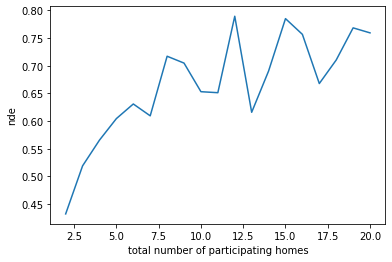

In [42]:
plt.plot(range(2, 21), ndes)
plt.ylabel('nde')
plt.xlabel("total number of participating homes")

In [ ]:
#Iteratively adding homes to global model, trial 1
{'refrigerator1_Train_home_[2126]_Test_home_[2126]_total_homes_1': [0.09093445539474487, -0.014985910154828641, 0.45236979144305295, 0.9847796914909418, 0.701257628591099, 26.599626913521533], 'refrigerator1_Train_home_[3700, 6672, 7021, 335, 142]_Test_home_[335]_total_homes_1': [0.0656757652759552, -0.09652668914534113, 0.4245840864192342, 0.7664727537163236, 0.5843863017219274, 48.183727707719186], 'refrigerator1_Train_home_[2358, 2126, 11878, 5058, 9973, 5058, 7069, 526, 7021, 10164]_Test_home_[7021]_total_homes_1': [0.13397249579429626, -0.40018523219510693, 0.2910230798751214, 0.8850934777759952, 0.7701192994727751, 61.13399976295241], 'refrigerator1_Train_home_[3700, 142, 9053, 690, 10983, 183, 9053, 9973, 2358, 6672, 10811, 3700, 9290, 3996, 9004]_Test_home_[6672]_total_homes_1': [0.042496636509895325, 0.037969506482425586, 0.413924206725173, 0.8057882388974359, 0.6416308549043926, 33.92659721210321], 'refrigerator1_Train_home_[3996, 10811, 10182, 387, 526, 2126, 10983, 3996, 7021, 2561, 6178, 3700, 3488, 6672, 6672, 10182, 7365, 10811, 10164, 11878]_Test_home_[2126]_total_homes_1': [0.0644366666674614, 0.0145451466579819, 0.412771484028735, 0.8989641910315869, 0.680854499185984, 24.28168685511104], 'refrigerator1_Train_home_[8825, 3383, 6240, 6526, 387, 7069, 7021, 11878, 2358, 526, 5058, 7069, 5058, 3488, 335, 10182, 142, 3996, 3976, 387, 6672, 9053, 3700, 6672, 6526]_Test_home_[2358]_total_homes_1': [0.10874124616384506, 0.03966814702721477, 0.25522453925462363, 1.0269965594230064, 0.74486410858908, 33.9225955917141], 'refrigerator1_Train_home_[6178, 11878, 3383, 335, 6672, 183, 1417, 3976, 7021, 690, 183, 10164, 3383, 10983, 10182, 3700, 5058, 6240, 7069, 6672, 6526, 7021, 10983, 6178, 3996, 8825, 2126, 2561, 11878, 6240]_Test_home_[6240]_total_homes_1': [0.12406780570745468, -0.11294304342360695, 0.12954695709894726, 1.1009816272218376, 0.8701382041537851, 31.04498042525673], 'refrigerator1_Train_home_[3488, 9290, 11878, 3383, 3700, 6672, 526, 7021, 3383, 3488, 10811, 7021, 2561, 6178, 6672, 10983, 142, 3700, 7021, 2561, 6672, 690, 1417, 9053, 9973, 2358, 9053, 387, 9290, 11878, 7365, 526, 6178]_Test_home_[3700]_total_homes_1': [0.06764775514602661, -0.271149884470667, 0.43842910749882513, 0.7538627637057354, 0.8185075529036647, 30.15869901375244]}

In [14]:
len(best_models)

11

In [ ]:
#10 best models: drye1, train 3000, test 3000 aug
drye1_trial1

In [ ]:
test_homes = [
    4628,
    5192
]

In [ ]:
random_select = [33]

In [16]:
for i in range(len(best_models)):
    best_models[i].cpu()
    torch.save(best_models[i].state_dict(), PATH+"\\seq2point_refrigerator_model_power_ratio_filter_"+str(random_select[i])+"_homes_trial1.pth")

In [ ]:
model_test = LSTM(
        config_['in_channels'],
        config_['out_channels'],
        config_['kernel_size'],
        config_['hidden_size_1'],
        config_['hidden_size_2'],
        config_['fc1'],
        config_['batch_size'],
        config_['window_size'])

In [ ]:
model_test.load_state_dict(torch.load(PATH+"\\seq2point_refrigerator_model_squ_foot_filter_2_homes_trial1.pth"))
model_test.eval()

In [ ]:
best_models[0].cpu()

In [ ]:
torch.save(best_models[0].state_dict(), PATH+"\\global_refrigerator_model_test_home_142_single_home_jan27.pth")

In [ ]:
model.cpu()
torch.save(model.state_dict(), PATH+"\\dryer_model_total_houses_"+str(1)+"_trial_3.pth")

In [ ]:
#results for training refrigerator1 using MSE 0.09 hyperparameters
{'Train_home_[  142   145   387   690   950  1240  1417  2358  2561  2786  3383  3488\n  3700  3976  3996  4628  5058  5367  5982  6069  6178  6526  6594  6672\n  6703  6907  7021  7069  8162  8627  8825  9002  9004  9053  9290 10164\n   984  5192  7365  8849 11878   183   335   526  2126  6240  6564  7935\n  9973 10182 10811 10983 11785]_Test_home_2358_trial_0': [0.06386639177799225, 0.5221559965325657, 0.756976470829962, 0.539304368116004, 0.18637192749997455, 23.918407925437478]}

In [ ]:
best_models[0].cpu()

In [ ]:
def load_model(appliance, num_homes, model_type, trial):
    model_test = LSTM(
        config_['in_channels'],
        config_['out_channels'],
        config_['kernel_size'],
        config_['hidden_size_1'],
        config_['hidden_size_2'],
        config_['fc1'],
        config_['batch_size'],
        config_['window_size'])
    
    model_type = 'global'
    
    root_path = r"C:\Users\aar245\Desktop\privacy_preserving_nn\models_squ_foot_filter\\"
    
    model_test.load_state_dict(
        torch.load(root_path+str(model_type)+"_"+str(appliance)+"_model_squ_foot_filter_"+str(num_homes)+"_homes_trial"+str(trial)+".pth")
    )
    model_test.eval()
    
    return model_test

In [ ]:
def load_test_data_loader(appliance, test_home, test_month):    
    test_path = r"C:\Users\aar245\Desktop\privacy_preserving_nn\input\1min_real_"+str(test_month)+"2019.csv"
    test_dataset = PecanStreetDataset(test_path, str(appliance)+"1", config_['window_size'], [test_home])
    y_min = test_dataset.y_min
    y_max = test_dataset.y_max
    test_dataset = test_dataset[round(0.5*len(test_dataset)):]
    test_loader = DataLoader(dataset=test_dataset, batch_size=config_['batch_size'], shuffle = False, num_workers=0)

    return test_loader, y_min, y_max

In [ ]:
def create_true_and_pred_lists(appliance, num_homes, model_type, trial, test_loader, y_min, y_max):
    model_test = load_model(appliance, num_homes, model_type, trial)
    predictions = []
    true_vals = []
    model_type = 'global'
    for i, (inputs, outputs) in enumerate(test_loader):
        inputs, outputs = inputs.cpu(), outputs.cpu()
        prediction = model_test(inputs)
        predictions.append(prediction.detach().numpy())
        true_vals.append(outputs.detach().numpy())
    
    true_vals = [i for subitems in true_vals for i in subitems]
    true_vals = [i for subitems in true_vals for i in subitems]
    true_vals = denormalize(true_vals, y_min, y_max)
    
    predictions = [i for subitems in predictions for i in subitems]
    predictions = [i for subitems in predictions for i in subitems]
    predictions = denormalize(predictions, y_min, y_max)
    
    return true_vals, predictions

In [ ]:
def denormalize(sequence, y_min, y_max):
    sequence = np.add(np.multiply(sequence, y_max - y_min), y_min)
    sequence = np.exp(sequence) - 1
    return sequence

In [ ]:
def plot_true_and_pred(true, predictions, view):
    if view == 0:
        plt.figure(figsize=(20,4))
        plt.plot(true)
        plt.plot(predictions, alpha = 0.7)
        plt.plot([np.mean(true)]*len(true))
        plt.legend(['true', 'pred', 'mean'])
        
    elif view > 0:
        plt.figure(figsize=(20,4))
        plt.plot(true[0:view])
        plt.plot(predictions[0:view], alpha = 0.7)
        plt.plot([np.mean(true)]*view)
        plt.legend(['true', 'pred', 'mean'])

In [ ]:
def calculate_model_metrics(true, predictions, y_min, y_max, model_type, num_homes, test_home):
    local_precision = precision(predictions, true)
    local_recall = recall(predictions, true)

    mse = np.mean(np.square(predictions - true))
    r2 = metrics.r2_score(true, predictions)
    f1 = f1_score(local_precision, local_recall)
    nep = np.sum(abs(predictions - true))/np.sum(true)
    nde = np.sum(np.square(predictions - true))/np.sum(np.square(true))
    mae = np.sum(abs(predictions - true))/len(true)
    
    #results = {"MSE":mse, "R2":r2, "F1":f1, "NEP":nep, "NDE":nde, "MAE":mae}
    results = {str(model_type)+"_#TrainHomes:"+str(num_homes)+"_TestHomeID:"+str(test_home):[mse, r2, f1, nep, nde, mae]}
    return results

In [ ]:
#box-cox normalization
for id in home_ids[0:1]:
    test_loader, y_min, y_max = load_test_data_loader("refrigerator", 142, "dec")
    true, pred = create_true_and_pred_lists(best_models[0], test_loader, y_min, y_max)
    plot_true_and_pred(true, pred, 5000)

In [ ]:
#standard normalization
for id in home_ids[0:1]:
    test_loader, y_min, y_max = load_test_data_loader("refrigerator", 5058, "dec")
    true, pred = create_true_and_pred_lists(model_test, test_loader, y_min, y_max)
    plot_true_and_pred(true, pred, 2000)

In [ ]:
[0.08261062204837799, 0.0006756758968593513, 0.47869045869881166, 0.7716401972127334, 0.6100338455022384, 40.55996281584161, 4326.6523]

In [ ]:
calculate_model_metrics(true, pred, y_min, y_max)

In [ ]:
calculate_model_metrics(true, pred, y_min, y_max)

In [ ]:
"attention_boxcox_global_refrigerator_model_test_home_5058_all_homes_trial0.pth"

In [ ]:
test_inputs = []
predictions = []
true_vals = []

In [ ]:
model.cpu()

In [ ]:
test_path = r"C:\Users\aar245\Desktop\privacy_preserving_nn\input\1min_real_dec2019.csv"

In [ ]:
test_dataset = PecanStreetDataset(test_path, 'refrigerator1', 499, [142])

In [ ]:
test_loader = DataLoader(dataset=test_dataset, batch_size=config_['batch_size'], shuffle = False, num_workers=0)

In [ ]:
for i, (inputs, outputs) in enumerate(test_loader):
    inputs, outputs = inputs.cpu(), outputs.cpu()
    prediction = best_models[0](inputs)
    predictions.append(prediction.detach().numpy())
    true_vals.append(outputs.detach().numpy())
    test_inputs.append(inputs)

In [ ]:
predictions_flat = [i for sublist in predictions for i in sublist]

In [ ]:
predictions_flat = [i for sublist in predictions_flat for i in sublist]

In [ ]:
true_flat = [i for sublist in true_vals for i in sublist]

In [ ]:
true_flat = [i for sublist in true_flat for i in sublist]

In [ ]:
plt.plot(true_flat)
plt.plot(predictions_flat)


plt.legend(['prediction', 'true'])
#plt.plot(test_inputs[0][3])

In [ ]:
predictions_list = [i for subitems in predictions for i in subitems]

In [ ]:
predictions_list = [i for subitems in predictions_list for i in subitems]

In [ ]:
true_vals_list = [i for subitems in true_vals for i in subitems]

In [ ]:
true_vals_list = [i for subitems in true_vals_list for i in subitems]

In [ ]:
plt.figure(figsize=(20,4))
plt.plot(true_vals_list)
plt.plot(predictions_list)

plt.legend(['true', 'pred'])

In [ ]:
torch.save(model.state_dict(), PATH)

In [ ]:
model_test = LSTM(
        config_['in_channels'],
        config_['out_channels'],
        config_['kernel_size'],
        config_['hidden_size_1'],
        config_['hidden_size_2'],
        config_['fc1'],
        config_['fc2'],
        config_['kernel_size_2'])

In [ ]:
model_test.load_state_dict(torch.load(r"C:\Users\aar245.CORNELL\Desktop\privacy_preserving_nn\models\refrigerator_model_total_houses_53_trial_0.pth"))

In [ ]:
model_test.eval()

In [ ]:
train_homes = [
    [6069, 11878],
    [7069, 9053, 11878],
    [142, 9053, 6178, 11421],
    [3996, 9053, 10983, 11421, 7935],
    [5192, 3383, 10811, 7365, 142, 526],
    [11878, 335, 6564, 183, 6240, 9053, 7365],
    [8825, 7935, 9002, 2358, 7069, 1417, 335, 526],
    [5058, 6178, 8825, 6564, 8627, 10182, 7365, 6526, 3976],
    [11878, 8627, 5192, 6672, 183, 6240, 3488, 6703, 8825, 9290],
    [11785, 11878, 1417, 5058, 6240, 6526, 2126, 335, 6069, 8825, 6594, 9004, 9053, 3976, 7935],
    [3383, 183, 6526, 8825, 8627, 2126, 335, 6564, 9053, 7365, 11785, 3996, 6703, 11421, 3488, 6240, 2358, 6178, 10182, 10983],
    [142, 526, 1417, 10983, 335, 3996, 8627, 3383, 6564, 2358, 11785, 6703, 183, 3488, 7365, 3976, 8825, 10182, 6594, 5192, 6178, 9004, 387, 9053, 6240],
    [6240, 8825, 6069, 6564, 11785, 6178, 10983, 11878, 3488, 142, 7935, 5058, 6526, 9004, 9002, 3996, 9290, 10811, 526, 183, 7365, 5192, 3976, 9053, 1240, 3383, 11421, 6672, 2126, 7069],
    [387, 183, 7069, 6178, 9004, 6564, 6594, 1240, 3976, 9053, 3488, 7365, 10811, 10182, 2358, 3383, 3996, 11878, 142, 6526, 526, 6703, 2126, 8825, 6672, 6240, 9290, 9002, 335, 1417, 11785, 8627, 5058, 10983, 5192],
    [9002, 3488, 1240, 6672, 5058, 11878, 6240, 2126, 7935, 387, 183, 6178, 1417, 11785, 6526, 11421, 2358, 7365, 335, 3976, 526, 10811, 3383, 10983, 3996, 9290, 9053, 6703, 9004, 8627, 6069, 5192, 10182, 142, 6594, 7069, 6564, 8825]
]

In [ ]:
all_results = {}
for i in range(len(random_select)):
    for j in train_homes[i]:
        test_loader, y_min, y_max = load_test_data_loader("refrigerator", j, "dec")

        true, pred = create_true_and_pred_lists(
        appliance='refrigerator',
        num_homes=random_select[i],
        model_type='global',
        trial=1,
        test_loader=test_loader,
        y_min=y_min,
        y_max=y_max
    )

        all_results.update(calculate_model_metrics(true, pred, y_min, y_max, 'global', random_select[i], j))
    print(all_results)

In [ ]:
global_results = pd.DataFrame.from_dict(all_results, orient='index', columns=['mse', 'r2', 'f1', 'nep', 'nde', 'mae'])

In [ ]:
global_results.to_csv(r"C:\Users\aar245.CORNELL\Desktop\privacy_preserving_nn\global_squ_foot_filter.csv")

In [ ]:
avg_df = pd.DataFrame(columns = ['mse', 'r2', 'f1', 'nep', 'nde', 'mae'])
count = 0
for i in range(len(random_select)):
    df = pd.DataFrame(global_results[count:count+random_select[i]].mean()).T
    df.index = ['global'+"_"+str(random_select[i])+"_Homes"]
    count += int(random_select[i])
    avg_df = avg_df.append(df)

In [ ]:
avg_df

In [ ]:
def make_box_plots(data, metric):
    home_iter = [2,3,4,5,6,7,8,9,10,15,20,25,30,35,38]
    count = 0
    all_bldgs = []
    for j in range(len(home_iter)):
        bldgs = data[count:count+home_iter[j]][str(metric)].values
        all_bldgs.append(bldgs)
        count += home_iter[j]
    return plt.boxplot(all_bldgs, showmeans=True)

In [ ]:
make_box_plots(global_results, 'mse')

In [ ]:
old_global_results = pd.read_csv(r"C:\Users\aar245.CORNELL\Desktop\privacy_preserving_nn\global_vs_fl_corrected.csv", index_col=0)

In [ ]:
old_global_results = old_global_results[0:int(len(old_global_results)/2)-33]

In [ ]:
global_results.iloc[9:14]

In [ ]:
new_df = pd.DataFrame()

global_results.iloc[44:-73]

In [ ]:
new_df = new_df.append(global_results.iloc[44:-73])

In [ ]:
new_df

In [ ]:
def make_adjacent_box_plots(global_results, fl_results, metric):
    
    iters = []
    for result in global_results.index:
        iters.append(int(result.split(':')[1].split('_')[0]))
        
    home_iter = np.unique(iters)
    
    count = 0
    all_global_results = []
    all_fl_results = []
    
    for j in range(len(home_iter)):
        bldgs = global_results[count:count+home_iter[j]][str(metric)].values
        all_global_results.append(bldgs)
        count += home_iter[j]
        
    count = 0
    for j in range(len(home_iter)):
        bldgs = fl_results[count:count+home_iter[j]][str(metric)].values
        all_fl_results.append(bldgs)
        count += home_iter[j]
        
    all_data = [list(a) for a in zip(all_global_results, all_fl_results)]
    all_data = [item for sublist in all_data for item in sublist]
    
    positions = [1]
    labels = ['global']
    for i in range(len(all_data)-1):
        if i%2==0:
            positions.append(positions[i]+0.5)
        else:
            positions.append(positions[i]+1)

    labels = []
    for home in home_iter:
        labels.append(home)
        labels.append('')
    
    fig, ax = plt.subplots(figsize=(20, 4))
    bplot = ax.boxplot(
        all_data,
        notch=False,
        patch_artist=True,
        positions=positions,
        labels=labels,
        showmeans=True
    )
    
    #ax.set_xticklabels(labels, ha='center')
    plt.setp(ax.xaxis.get_majorticklabels())
    dx = 27/72.; dy = 0/72. 
    offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
    
    for label in ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + offset)
    
    ax.xaxis.set_ticks_position('none')
    
    ax.set_title("Global and FL Metrics for increasing quantity of homes")
    
    colors = []
    for i in range(int(len(labels)/2)):
        colors.append('blue')
        colors.append('red')
        
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

    ax.set_xlabel('Number of homes')
    ax.set_ylabel(str(metric))
    
    custom_lines = [Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='red', lw=4)]
    
    ax.legend(custom_lines, ['squ_foot', 'k_means'])

    plt.show()


In [ ]:
make_adjacent_box_plots(new_df, old_global_results, 'f1')